In [3]:
import pandas as pd
import numpy as np
from datasets import df_info

def parse_coupon_dates(s:str,format="%d/%m",sep=",")->str:
    vals = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    trans_dict = {k:v for k,v in enumerate(vals,start=1)}
    months = []
    if s and type(s)==str: #wenn leer, dann ist np.nan, aber bool(np.nan) = True
        for cp_dt in s.split(sep):
            ts = pd.to_datetime(cp_dt,format=format)
            months.append("AS-"+trans_dict[ts.month])
    return months

vals = df_info.loc[:,"COUPON DATES"].values
for val in vals:
     print(val," -> ", parse_coupon_dates(val))

01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
nan  ->  []
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/05,01/11  ->  ['AS-MAY', 'AS-NOV']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/05,

In [20]:
from cpi import RefCPI

cpi = RefCPI()
cpi.series

REF_DATE
1991-01-01     82.0
1991-02-01     82.0
1991-03-01     82.3
1991-04-01     82.3
1991-05-01     82.7
              ...  
2023-05-01    157.0
2023-06-01    157.2
2023-07-01    158.1
2023-08-01    158.7
2023-09-01    158.5
Name: VALUE, Length: 393, dtype: float64

In [35]:
import pandas as pd
from tqdm import tqdm
from bond  import Bond,ILB
import pickle

with pd.ExcelFile("data/can.xlsx") as xls:
    df_prices = pd.read_excel(xls,"Price",index_col=0,parse_dates=True)
    df_prices.columns = df_prices.columns.map(str)

with pd.ExcelFile("data/can.xlsx") as xls:
    df_info = pd.read_excel(xls,"Info",index_col=0,dtype={"COUPON DATE":str,"ISSUE DATE":str,"REDEMPTION DATE":str,'START YEAR':str,'MATURITY YEAR':str})
    df_info.index = df_info.index.map(str)
    df_info.loc[:,"ISSUE DATE"] = df_info.loc[:,"ISSUE DATE"].map(pd.Timestamp)
    df_info.loc[:,"REDEMPTION DATE"] = df_info.loc[:,"REDEMPTION DATE"].map(pd.Timestamp)

all_bonds = df_info.index
ilbs = df_info[df_info["TYPE"]=="ILB"].index #nur vom typ ilb
noms = df_info[df_info["TYPE"]=="NOM"].index

bond_objs = []
for bond in all_bonds:
    name = df_info.loc[bond,"NAME"]
    issue_date = df_info.loc[bond,"ISSUE DATE"]
    redem_date = df_info.loc[bond,"REDEMPTION DATE"]
    prices = df_prices[bond]
    coupon_dates = Bond.parse_coupon_dates(df_info.loc[bond,"COUPON DATES"])

    if df_info.loc[bond,"TYPE"] == "ILB":
        coupon = df_info.loc[bond,"INDEX LINKED COUP"]
        ilb = ILB(issue_date,redem_date,coupon,coupon_freq=coupon_dates,id=bond,prices=prices,name=name)
        if ilb.redem_date < ilb.max_poss_redem_date: #nur dann kann der historische cashflow und damit ytm berechnet werden
            bond_objs.append(ilb)
    else:
        coupon = df_info.loc[bond,"COUPON"]
        bond_objs.append(Bond(issue_date,redem_date,coupon,coupon_freq=coupon_dates,id=bond,prices=prices,name=name))
"""
df = pd.DataFrame() #holds only date|YTMs for every bond -> csv
data = {} #holds yield curve dataframe date|price|TTM|YTM für jeden bond
for bond in tqdm(bond_objs):
     print("EVALUATING:", bond.id)
     yc = bond.yield_curve()
     data[bond.id] = bond.yield_curve()
     df[bond.id] = yc["YTM"]
"""

  0%|                                                                                                                                  | 0/27 [00:00<?, ?it/s]

EVALUATING: 597973
597973 :  2021-11-29 :  Failed to converge after 50 iterations, value is 6.942429510285882e+42.
597973 :  2021-11-30 :  Failed to converge after 50 iterations, value is 2.794406556474315e+71.
597973 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


  4%|████▌                                                                                                                     | 1/27 [01:26<37:30, 86.54s/it]

597973 :  2021-11-29 :  Failed to converge after 50 iterations, value is 6.942429510285882e+42.
597973 :  2021-11-30 :  Failed to converge after 50 iterations, value is 2.794406556474315e+71.
597973 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 49197V
49197V :  2020-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


  7%|█████████                                                                                                                 | 2/27 [01:43<19:07, 45.89s/it]

49197V :  2020-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491985
491985 :  2021-05-31 :  Failed to converge after 50 iterations, value is 7.643863247076988e+47.
491985 :  2021-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 11%|█████████████▌                                                                                                            | 3/27 [02:11<14:57, 37.38s/it]

491985 :  2021-05-31 :  Failed to converge after 50 iterations, value is 7.643863247076988e+47.
491985 :  2021-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491987
491987 :  2022-05-31 :  Failed to converge after 50 iterations, value is 3.861060618166953e+54.
491987 :  2022-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 15%|██████████████████                                                                                                        | 4/27 [02:39<12:57, 33.79s/it]

491987 :  2022-05-31 :  Failed to converge after 50 iterations, value is 3.861060618166953e+54.
491987 :  2022-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491989
491989 :  2023-05-31 :  Failed to converge after 50 iterations, value is 3.0352575243824747e+62.
491989 :  2023-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 19%|██████████████████████▌                                                                                                   | 5/27 [03:10<11:57, 32.63s/it]

491989 :  2023-05-31 :  Failed to converge after 50 iterations, value is 3.0352575243824747e+62.
491989 :  2023-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 49197U


 22%|███████████████████████████                                                                                               | 6/27 [03:33<10:21, 29.61s/it]

EVALUATING: 491986
491986 :  2021-11-30 :  Failed to converge after 50 iterations, value is 4.3162985907174586e+51.
491986 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 26%|███████████████████████████████▋                                                                                          | 7/27 [03:59<09:29, 28.45s/it]

491986 :  2021-11-30 :  Failed to converge after 50 iterations, value is 4.3162985907174586e+51.
491986 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491970
491970 :  2021-11-30 :  Failed to converge after 50 iterations, value is 3.5071013922812576e+70.
491970 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 30%|████████████████████████████████████▏                                                                                     | 8/27 [04:27<08:58, 28.34s/it]

491970 :  2021-11-30 :  Failed to converge after 50 iterations, value is 3.5071013922812576e+70.
491970 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491988
491988 :  2022-11-30 :  Failed to converge after 50 iterations, value is 5.8497321337335036e+60.
491988 :  2022-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 33%|████████████████████████████████████████▋                                                                                 | 9/27 [05:02<09:02, 30.14s/it]

491988 :  2022-11-30 :  Failed to converge after 50 iterations, value is 5.8497321337335036e+60.
491988 :  2022-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 5771H1
5771H1 :  2021-11-29 :  Failed to converge after 50 iterations, value is 5.298662378626234e+47.
5771H1 :  2021-11-30 :  Failed to converge after 50 iterations, value is 1.753347148893134e+74.
5771H1 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 37%|████████████████████████████████████████████▊                                                                            | 10/27 [05:22<07:43, 27.26s/it]

5771H1 :  2021-11-29 :  Failed to converge after 50 iterations, value is 5.298662378626234e+47.
5771H1 :  2021-11-30 :  Failed to converge after 50 iterations, value is 1.753347148893134e+74.
5771H1 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 846564


 41%|█████████████████████████████████████████████████▎                                                                       | 11/27 [08:49<21:55, 82.21s/it]

EVALUATING: 610451


 44%|█████████████████████████████████████████████████████▎                                                                  | 12/27 [13:30<35:38, 142.59s/it]

EVALUATING: 46269V


 48%|█████████████████████████████████████████████████████████▊                                                              | 13/27 [16:39<36:31, 156.54s/it]

EVALUATING: 2180M7


 52%|██████████████████████████████████████████████████████████████▏                                                         | 14/27 [19:05<33:15, 153.51s/it]

EVALUATING: 6487P3


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 15/27 [21:18<29:26, 147.22s/it]

EVALUATING: 794D5D


 59%|███████████████████████████████████████████████████████████████████████                                                 | 16/27 [23:06<24:51, 135.63s/it]

EVALUATING: 860K02


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 17/27 [24:10<18:59, 113.99s/it]

EVALUATING: 650WAD


 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 18/27 [24:37<13:09, 87.70s/it]

EVALUATING: 658V0W


 70%|█████████████████████████████████████████████████████████████████████████████████████▏                                   | 19/27 [24:50<08:44, 65.54s/it]

EVALUATING: 651FLY
651FLY :  2023-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 74%|█████████████████████████████████████████████████████████████████████████████████████████▋                               | 20/27 [24:58<05:36, 48.10s/it]

651FLY :  2023-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 3925TN


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                           | 21/27 [26:26<06:00, 60.01s/it]

EVALUATING: 5694XD


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22/27 [27:44<05:27, 65.56s/it]

EVALUATING: 6561K8


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████                  | 23/27 [29:00<04:34, 68.59s/it]

EVALUATING: 8118P5


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24/27 [30:37<03:50, 76.99s/it]

EVALUATING: 853J3Z
853J3Z :  2019-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25/27 [30:52<01:56, 58.41s/it]

853J3Z :  2019-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 2360RY


/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)


2360RY :  2021-01-07 :  Failed to converge after 50 iterations, value is nan.


/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)


2360RY :  2021-01-08 :  Failed to converge after 50 iterations, value is nan.
2360RY :  2021-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)
/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26/27 [31:12<00:46, 46.92s/it]

2360RY :  2021-01-07 :  Failed to converge after 50 iterations, value is nan.
2360RY :  2021-01-08 :  Failed to converge after 50 iterations, value is nan.
2360RY :  2021-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 615GG0
615GG0 :  2022-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [31:19<00:00, 69.61s/it]

615GG0 :  2022-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


In [36]:
with open("export/ytm_dataframes.pickle","wb") as f:
    pickle.dump(data,f)

df.to_csv("export/ytms.csv")

In [81]:
import ipywidgets as widgets
dd = widgets.Dropdown(options=df.columns,description="Bond")
log_chk = widgets.Checkbox(description="log")

def plot_ytm(bond:str,log:bool):
    fig, ax = plt.subplots()
    df_b = df[[bond]].dropna()
    df_b["redem_date"] = df_b.index.max()
    df_b["TTM"] = df_b["redem_date"] - df_b.index
    df_b["TTM"] = df_b["TTM"].map(lambda d: d.days)/365
    sns.lineplot(data=df_b,x="TTM",y=bond)
    if log:
        plt.yscale("log")
    plt.show()
    display(df_info.loc[bond,:])
out = widgets.interactive_output(plot_ytm, {"bond":dd,"log":log_chk})
display(dd,log_chk,out)

Dropdown(description='Bond', options=('597973', '49197V', '491985', '491987', '491989', '49197U', '491986', '4…

Checkbox(value=False, description='log')

Output()

In [26]:
yc1 = bond_objs[1].yield_curve()

49197V :  2020-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


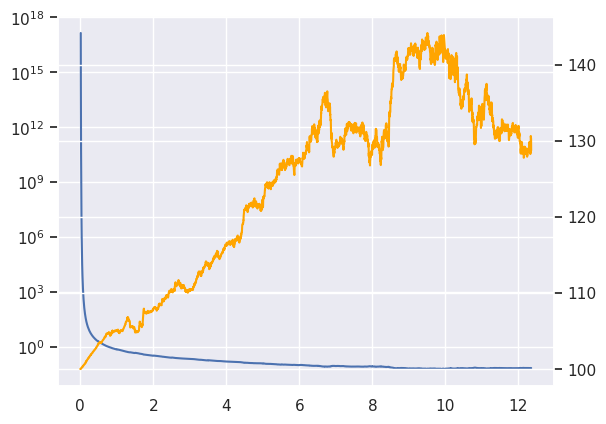

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
x = yc.loc[:,"TTM"].values
y = yc.loc[:,"YTM"].values
p = yc.loc[:,"P"].values
plt.plot(x,y)
plt.yscale("log")
plt.twinx()
plt.plot(x,p,color="orange")
plt.show()

In [30]:
df = pd.DataFrame()
df["bond0"] = yc["YTM"]
df["bond1"] = yc1["YTM"]

/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeInde

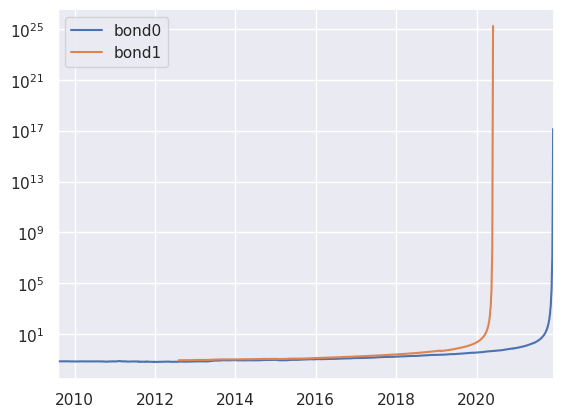

In [33]:
df.plot.line()
plt.yscale("log")

In [20]:
import pickle

with open("export/ytm_dataframes.pickle","rb") as f:
    data = pickle.load(f)

dfs = []
for b,bdf in data.items():
    bdf[b] = bdf["YTM"]
    dfs.append(bdf[b])
ytms = pd.concat(dfs,axis=1)

In [22]:
ytms.to_csv("export/ytms.csv")